# Predict 20 Timesteps, Electrode 5

In [ ]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../')
from brain2brain import utils, generators, models
%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed

from scipy.stats import pearsonr

In [3]:
train_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_paths[0])[1]
# Electrodes
electrode_count = 1
electrode = 5
lookback = 100
pred_length = 20
# Training Generator
train_generator = generators.FGenerator(file_paths=train_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=True,
                                        teacher_forcing=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_paths,
                                        lookback=lookback,
                                        length=pred_length,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=[electrode],
                                        electrode_output_ix=electrode,
                                        shuffle=False,
                                        teacher_forcing=True)

(5429, 114)


In [4]:
hidden_units = 128
dropout = 0.05
train, inf_encoder_model, inf_decoder_model = models.define_enc_dec_model_jeddy_o2o(hidden_units, dropout)

In [5]:
train.compile(optimizer='rmsprop', loss='logcosh')
train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 66560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  66560       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [6]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=2,
#             mode="min"
#         )
]
history = train.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=100,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 12 steps, validate for 4 steps
Epoch 1/100
 1/12 [=>............................] - ETA: 2:25

ResourceExhaustedError:  [_Derived_]  OOM when allocating tensor with shape[100,1024,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node CudnnRNN}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[model/lstm/StatefulPartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_6410]

Function call stack:
distributed_function -> distributed_function -> distributed_function


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [127]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int, enc_tail_len=50):
    encode_series = encoder_input_data[0][sample_ix:sample_ix+1,:,:] 
    pred_series = models.decode_sequence_o2o(inf_encoder_model_3,
                                             inf_decoder_model_3, 
                                             input_seq=encode_series,
                                             pred_steps=pred_steps)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    print(f"Correlation: {r}. P: {p}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [128]:
val_batch = val_generator[0]

In [129]:
len(val_batch[0][0])

1024

Correlation: -0.14091139487008844. P: 0.6978042442360234


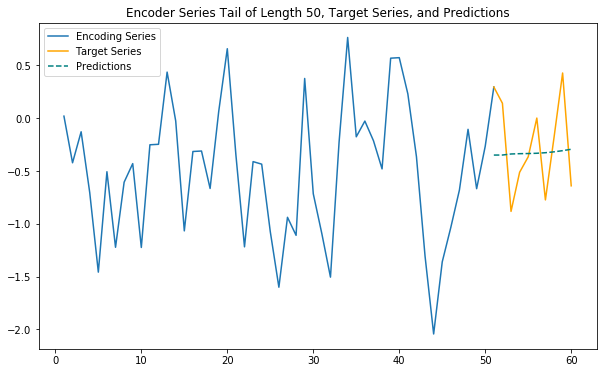

In [130]:
predict_and_plot(val_batch[0], val_batch[1], sample_ix=0, pred_steps=10)

In [133]:
def get_corr_mae(encoder_input_data, decoder_target_data, sample_ix, pred_steps: int,
                 enc_tail_len=50, verbose=True):
    encode_series = encoder_input_data[0][sample_ix:sample_ix+1,:,:] 
    pred_series = models.decode_sequence_o2o(inf_encoder_model_3,
                                             inf_decoder_model_3, 
                                             input_seq=encode_series,
                                             pred_steps=pred_steps)
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ix,:,:1].reshape(-1,1)
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    r, p = pearsonr(pred_series.reshape(-1), target_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [134]:
n_rows = val_batch[0][0].shape[0]
r_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(val_batch[0], val_batch[1], sample_ix=sample_ix, pred_steps=10, verbose=False)
    r_array[sample_ix] = r
    sample_maes[sample_ix] = mae
z_mean = np.mean(r_array)
batch_r = np.tanh(z_mean)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Batch Mae: {batch_mae}")

Batch_r: 0.09852124768042982
Batch Mae: 0.6221037421592859
